In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
from tqdm.autonotebook import tqdm, trange

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/tmp/ipykernel_8522/3230925853.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [6]:
# total_df.tradetime = total_df.close
# total_df.drop(['close', 'pr_close'], 1, inplace = True)
# total_df.rename(columns={'tradetime':'close'}, inplace=True)

In [36]:
data = total_df[total_df.secid == 'SBER'].drop('secid', 1).close #[['tradedate','close']].set_index('tradedate')

/tmp/ipykernel_8522/627558537.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = total_df[total_df.secid == 'SBER'].drop('secid', 1).close #[['tradedate','close']].set_index('tradedate')


In [52]:
# data_train =   data[:'2022-02-18'].to_numpy()
# data_val = data['2022-05-01':].to_numpy()

# scaler = StandardScaler()
# data_train = scaler.fit_transform(data_train)
# data_val = scaler.transform(data_val)

# print(f'Train shape: {data_train.size}\nVal shape: {data_val.size}')

train_data = data[ : round(data.shape[0]*0.80) ].to_numpy()
train_data1 = data[ : round(data.shape[0]*0.53) ].to_numpy()
train_data2 = data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ].to_numpy()
val_data = data[ round(data.shape[0]*0.80) : ].to_numpy()

# scaler = StandardScaler().fit(train_data.reshape(-1,1))
# train_data1 = scaler.transform(train_data1.reshape(-1,1))
# train_data2 = scaler.transform(train_data2.reshape(-1,1))
# val_data = scaler.transform(val_data.reshape(-1,1))

print(f'Train shape: {train_data.size}\nVal shape: {val_data.size}')

Train shape: 6340
Val shape: 1585


In [53]:
from torch.nn import MSELoss
criterion = MSELoss()

In [54]:
real1 = train_data1[1:]
pred1 = np.roll(train_data1, 1)[1:]

In [56]:
res1 = criterion(torch.Tensor(real1), torch.Tensor(pred1))
res1

tensor(2.6364)

In [60]:
real2 = train_data2[1:]
pred2 = np.roll(train_data2, 1)[1:]

In [62]:
res2 = criterion(torch.Tensor(real2), torch.Tensor(pred2))
res2

tensor(0.8692)

In [71]:
res2.item()

0.8691919445991516

In [83]:
np.mean([res1.item(),res2.item()])

1.7528177797794342

In [87]:
real3 = val_data[1:]
pred3 = np.roll(val_data, 1)[1:]

In [90]:
res3 = criterion(torch.Tensor(real3), torch.Tensor(pred3))
res3

tensor(1.2626)

In [91]:
winrate(real3, pred3)

0.4832596336070752

In [94]:
wr1 = winrate(real1, pred1)

In [95]:
wr2 = winrate(real2, pred2)

In [96]:
np.mean([wr1,wr2])

0.45762458855207955

In [115]:
always_grow = np.arange(0,len(real3))

In [116]:
real3

array([166.13, 165.75, 165.18, ..., 268.36, 268.25, 268.31])

In [117]:
winrate(real3, always_grow)

0.5319014529374605

In [114]:
np.mean([0.5028585040495474, 0.5041061276058117])

0.5034823158276795

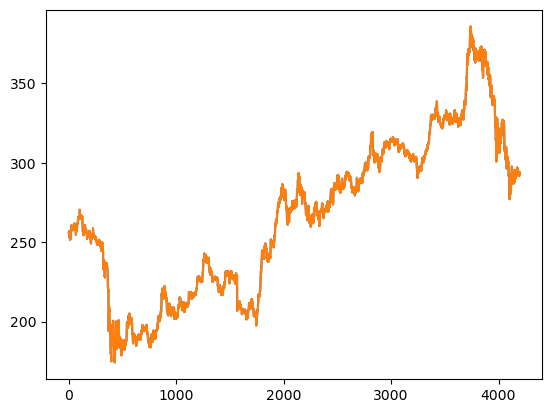

In [65]:
plt.plot(real1[:])
plt.plot(pred1[:])

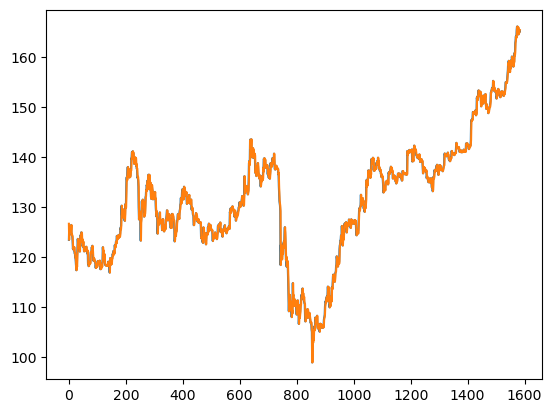

In [67]:
plt.plot(real2[:])
plt.plot(pred2[:])

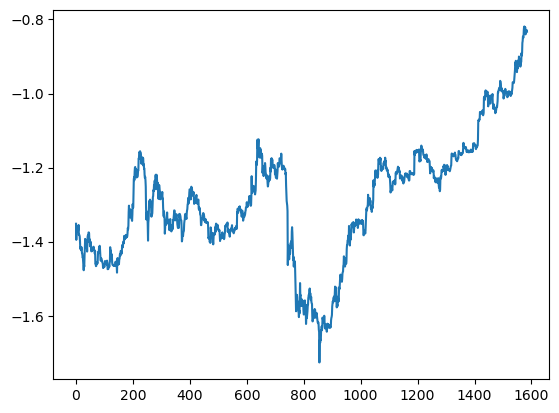

In [7]:
plt.plot(train_data2)

In [10]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [11]:
# SEQUENCE_SIZE = 26

# x_train, y_train = to_sequences(SEQUENCE_SIZE, data_train)
# x_val, y_val = to_sequences(SEQUENCE_SIZE, data_val)


# train_dataset = TensorDataset(x_train, y_train)
# val_dataset  = TensorDataset(x_val, y_val)                          


# train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

lookback = 16
horizon = 1

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5753, 16, 1]), y_train: torch.Size([5753, 1])
x_val: torch.Size([1569, 16, 1]), y_val: torch.Size([1569, 1])


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, fcst_horizon=1):
        '''
        LSTM с последующим дропаутом и двумя линейными слоями
        input_size: кол-во фичей(или совместно подаваемых рядов)
        hidden_size: внутренняя размерность каналов краткосрочной и долговсрочной памяти
        num_layers: количество LSTM слоёв
        dropout: коэффициент dropout
        fcst_horizon: длина горизонта прогнозировния
        '''
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.fcst_horizon = fcst_horizon
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(self.hidden_size, 32)
        self.fc2 = nn.Linear(32, self.fcst_horizon)

    def forward(self, x):
        x, _ = self.lstm(x) # Prediction и логи долгосрочной памяти( x.shape = (B, len_seq, hidden_size))
        x = self.dropout(x[:,-1,:])# Отбираем в B матрицах размера (len_seq,hidden_size) только последние вектора
        x = self.fc1(x) #Постепенно из 64 мерного пространства сводим в 1 мерное
        x = self.fc2(x) #Постепенно из 64 мерного пространства сводим в 1 мерное
        return x

In [35]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res

In [43]:
model = LSTMModel(input_size=1, hidden_size=512, num_layers=1, dropout=0.0, fcst_horizon=1).to(device)

In [51]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,) )
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    if val_loss < 0.00006:
        torch.save(model.state_dict(), f'ВЕСА/LSTM(U) 1D|W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.012802 Validation Loss: 0.000376


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.000628 Validation Loss: 0.000306


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.000522 Validation Loss: 0.000380


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.000542 Validation Loss: 0.000302


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.000506 Validation Loss: 0.000278


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.000518 Validation Loss: 0.000293


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.000525 Validation Loss: 0.000272


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.000463 Validation Loss: 0.000314


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.000463 Validation Loss: 0.000259


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.000462 Validation Loss: 0.000284


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.000570 Validation Loss: 0.000284


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.000497 Validation Loss: 0.000250


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.000455 Validation Loss: 0.000265


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.000502 Validation Loss: 0.000248


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.000423 Validation Loss: 0.000252


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.000413 Validation Loss: 0.000259


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.000449 Validation Loss: 0.000257


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 1.5000e-03.
Epoch 18 / 50,Train Loss: 0.000441 Validation Loss: 0.000260


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.000417 Validation Loss: 0.000236


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.000414 Validation Loss: 0.000240


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 0.000422 Validation Loss: 0.000239


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.000412 Validation Loss: 0.000242


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 7.5000e-04.
Epoch 23 / 50,Train Loss: 0.000402 Validation Loss: 0.000240


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 0.000401 Validation Loss: 0.000234


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 0.000403 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 50,Train Loss: 0.000404 Validation Loss: 0.000235


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.000404 Validation Loss: 0.000234


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 0.000406 Validation Loss: 0.000237


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 3.7500e-04.
Epoch 29 / 50,Train Loss: 0.000405 Validation Loss: 0.000237


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 50,Train Loss: 0.000404 Validation Loss: 0.000238


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.000396 Validation Loss: 0.000234


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 0.000396 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 1.8750e-04.
Epoch 33 / 50,Train Loss: 0.000400 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 50,Train Loss: 0.000396 Validation Loss: 0.000236


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.000397 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 0.000395 Validation Loss: 0.000234


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 9.3750e-05.
Epoch 37 / 50,Train Loss: 0.000394 Validation Loss: 0.000234


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 50,Train Loss: 0.000396 Validation Loss: 0.000232


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.000409 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 0.000396 Validation Loss: 0.000235


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41 / 50,Train Loss: 0.000393 Validation Loss: 0.000234


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 4.6875e-05.
Epoch 42 / 50,Train Loss: 0.000391 Validation Loss: 0.000235


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 50,Train Loss: 0.000395 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 50,Train Loss: 0.000391 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45 / 50,Train Loss: 0.000396 Validation Loss: 0.000232


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00046: reducing learning rate of group 0 to 2.3438e-05.
Epoch 46 / 50,Train Loss: 0.000391 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 / 50,Train Loss: 0.000389 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48 / 50,Train Loss: 0.000393 Validation Loss: 0.000233


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49 / 50,Train Loss: 0.000390 Validation Loss: 0.000234


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00050: reducing learning rate of group 0 to 1.1719e-05.
Epoch 50 / 50,Train Loss: 0.000392 Validation Loss: 0.000233
Training complete in 0m 12s


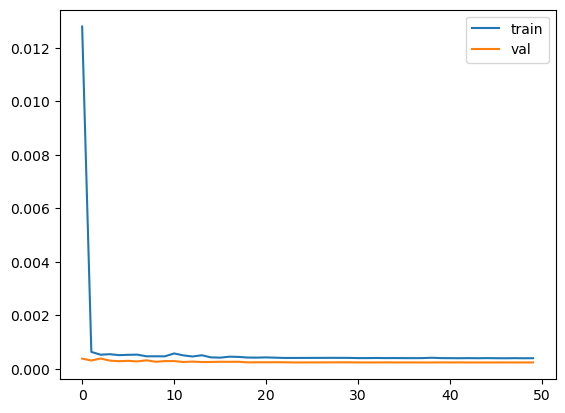

In [60]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.legend(['train','val'])

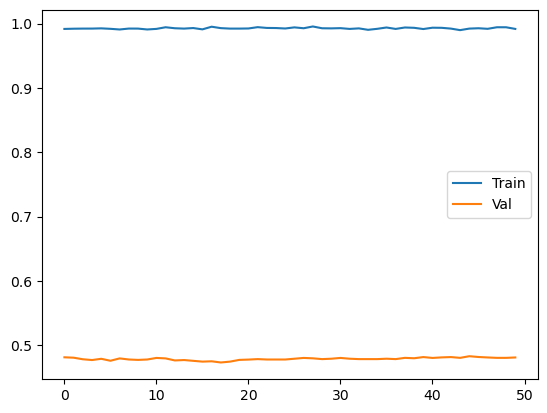

In [61]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

In [65]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)        

In [66]:
winrate(y_val.reshape(-1,), predictions1)

0.48086734693877553

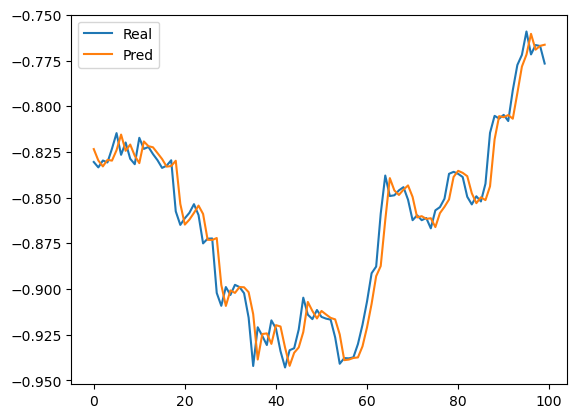

In [67]:
plt.plot(y_val[:100])
plt.plot(predictions1[:100])
plt.legend(['Real','Pred'])

In [69]:
y_val = scaler.inverse_transform(y_val)

In [71]:
predictions1 = scaler.inverse_transform(predictions1.reshape(-1,1))

In [72]:
criterion(torch.Tensor(y_val), torch.Tensor(predictions1))

tensor(1.2908)

In [73]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [74]:
winrate(y_train.reshape(-1,), predictions2)

0.46748956884561893

In [77]:
y_train = scaler.inverse_transform(y_train)

In [79]:
predictions2 = scaler.inverse_transform(predictions2.reshape(-1,1))

In [80]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(2.1614)

In [ ]:
torch.save(model.state_dict(), f'ЧВЕСА/[512,1,0.0]LSTM(U) 1D|W=0.4808, TL=1.9908 VL=1.8614' )